# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0, 0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
# np.random.seed(42)
np.random.seed(None)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
# print('\n\nlogits:\n')
# display(predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
# display(target_index)
# print('\n\n')
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
# print('\n\nlogits:')
# display(predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
# print('\ntarget_index:')
# display(target_index)
# print('\n\n')
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradients are different at (0, 0). Analytic: -0.30429, Numeric: -0.08206


Почему-то численный градиент сходится с аналитическим только в том случае, когда `target_index` принимает всегда одно значение. Например, `target_index = [3, 3, 3]`. Но при этом я проверил код на CS231n, поэтому есть надежда, что дальше все будет работать, а проблема где-то в вычислении численного градиента

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
np.random.seed(42)

batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [14]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [36]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 74.466820
Epoch 1, loss: 70.662232
Epoch 2, loss: 69.530424
Epoch 3, loss: 69.193714
Epoch 4, loss: 69.093541
Epoch 5, loss: 69.063738
Epoch 6, loss: 69.054871
Epoch 7, loss: 69.052233
Epoch 8, loss: 69.051448
Epoch 9, loss: 69.051215


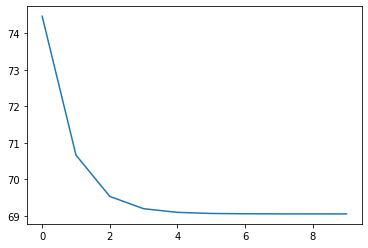

In [37]:
# let's look at the loss history!
plt.plot(loss_history)

In [54]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

Accuracy:  0.113


Epoch 0, loss: 74.498189
Epoch 1, loss: 70.671565
Epoch 2, loss: 69.533200
Epoch 3, loss: 69.194539
Epoch 4, loss: 69.093786
Epoch 5, loss: 69.063811
Epoch 6, loss: 69.054893
Epoch 7, loss: 69.052239
Epoch 8, loss: 69.051450
Epoch 9, loss: 69.051215
Epoch 10, loss: 69.051145
Accuracy after training for 100 epochs:  0.123


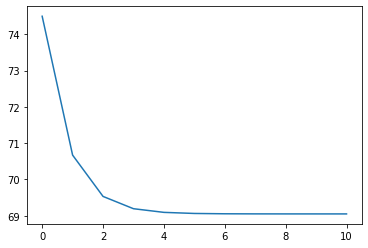

In [56]:
# Now, let's train more and see if it performs better
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)
plt.plot(loss_history)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

Learning Rate: 0.001 Regularization: 0.0001
Epoch 0, loss: 65.440554
Epoch 1, loss: 65.435289
Epoch 2, loss: 65.430045
Epoch 3, loss: 65.424822
Epoch 4, loss: 65.419621
Epoch 5, loss: 65.414441
Epoch 6, loss: 65.409283
Epoch 7, loss: 65.404146
Epoch 8, loss: 65.399029
Epoch 9, loss: 65.393933
Epoch 10, loss: 65.388858
Epoch 11, loss: 65.383803
Epoch 12, loss: 65.378769
Epoch 13, loss: 65.373755
Epoch 14, loss: 65.368761
Epoch 15, loss: 65.363787
Epoch 16, loss: 65.358833
Epoch 17, loss: 65.353899
Epoch 18, loss: 65.348984
Epoch 19, loss: 65.344089
Epoch 20, loss: 65.339213
Epoch 21, loss: 65.334357
Epoch 22, loss: 65.329520
Epoch 23, loss: 65.324701
Epoch 24, loss: 65.319902
Epoch 25, loss: 65.315121
Epoch 26, loss: 65.310359
Epoch 27, loss: 65.305615
Epoch 28, loss: 65.300890
Epoch 29, loss: 65.296183
Epoch 30, loss: 65.291495
Epoch 31, loss: 65.286824
Epoch 32, loss: 65.282172
Epoch 33, loss: 65.277537
Epoch 34, loss: 65.272920
Epoch 35, loss: 65.268321
Epoch 36, loss: 65.263739
Epoc

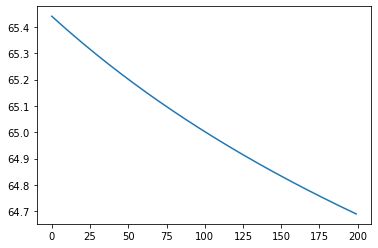

Learning Rate: 0.001 Regularization: 1e-05
Epoch 0, loss: 64.682422
Epoch 1, loss: 64.679668
Epoch 2, loss: 64.676922
Epoch 3, loss: 64.674183
Epoch 4, loss: 64.671450
Epoch 5, loss: 64.668724
Epoch 6, loss: 64.666005
Epoch 7, loss: 64.663293
Epoch 8, loss: 64.660588
Epoch 9, loss: 64.657890
Epoch 10, loss: 64.655198
Epoch 11, loss: 64.652513
Epoch 12, loss: 64.649834
Epoch 13, loss: 64.647162
Epoch 14, loss: 64.644497
Epoch 15, loss: 64.641838
Epoch 16, loss: 64.639186
Epoch 17, loss: 64.636540
Epoch 18, loss: 64.633901
Epoch 19, loss: 64.631268
Epoch 20, loss: 64.628642
Epoch 21, loss: 64.626022
Epoch 22, loss: 64.623408
Epoch 23, loss: 64.620801
Epoch 24, loss: 64.618200
Epoch 25, loss: 64.615605
Epoch 26, loss: 64.613016
Epoch 27, loss: 64.610434
Epoch 28, loss: 64.607857
Epoch 29, loss: 64.605287
Epoch 30, loss: 64.602723
Epoch 31, loss: 64.600165
Epoch 32, loss: 64.597613
Epoch 33, loss: 64.595067
Epoch 34, loss: 64.592527
Epoch 35, loss: 64.589993
Epoch 36, loss: 64.587465
Epoch

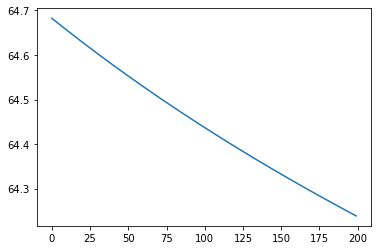

Learning Rate: 0.001 Regularization: 1e-06
Epoch 0, loss: 64.236148
Epoch 1, loss: 64.234321
Epoch 2, loss: 64.232496
Epoch 3, loss: 64.230675
Epoch 4, loss: 64.228856
Epoch 5, loss: 64.227041
Epoch 6, loss: 64.225228
Epoch 7, loss: 64.223419
Epoch 8, loss: 64.221612
Epoch 9, loss: 64.219809
Epoch 10, loss: 64.218008
Epoch 11, loss: 64.216211
Epoch 12, loss: 64.214416
Epoch 13, loss: 64.212624
Epoch 14, loss: 64.210835
Epoch 15, loss: 64.209050
Epoch 16, loss: 64.207267
Epoch 17, loss: 64.205487
Epoch 18, loss: 64.203709
Epoch 19, loss: 64.201935
Epoch 20, loss: 64.200164
Epoch 21, loss: 64.198395
Epoch 22, loss: 64.196629
Epoch 23, loss: 64.194866
Epoch 24, loss: 64.193106
Epoch 25, loss: 64.191349
Epoch 26, loss: 64.189595
Epoch 27, loss: 64.187843
Epoch 28, loss: 64.186094
Epoch 29, loss: 64.184348
Epoch 30, loss: 64.182605
Epoch 31, loss: 64.180864
Epoch 32, loss: 64.179126
Epoch 33, loss: 64.177391
Epoch 34, loss: 64.175659
Epoch 35, loss: 64.173930
Epoch 36, loss: 64.172203
Epoch

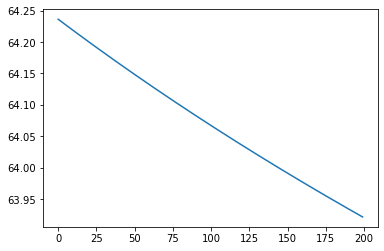

Learning Rate: 0.0001 Regularization: 0.0001
Epoch 0, loss: 63.930838
Epoch 1, loss: 63.930703
Epoch 2, loss: 63.930568
Epoch 3, loss: 63.930432
Epoch 4, loss: 63.930297
Epoch 5, loss: 63.930162
Epoch 6, loss: 63.930026
Epoch 7, loss: 63.929891
Epoch 8, loss: 63.929756
Epoch 9, loss: 63.929621
Epoch 10, loss: 63.929485
Epoch 11, loss: 63.929350
Epoch 12, loss: 63.929215
Epoch 13, loss: 63.929080
Epoch 14, loss: 63.928945
Epoch 15, loss: 63.928810
Epoch 16, loss: 63.928675
Epoch 17, loss: 63.928539
Epoch 18, loss: 63.928404
Epoch 19, loss: 63.928269
Epoch 20, loss: 63.928134
Epoch 21, loss: 63.927999
Epoch 22, loss: 63.927864
Epoch 23, loss: 63.927729
Epoch 24, loss: 63.927594
Epoch 25, loss: 63.927459
Epoch 26, loss: 63.927324
Epoch 27, loss: 63.927189
Epoch 28, loss: 63.927054
Epoch 29, loss: 63.926920
Epoch 30, loss: 63.926785
Epoch 31, loss: 63.926650
Epoch 32, loss: 63.926515
Epoch 33, loss: 63.926380
Epoch 34, loss: 63.926245
Epoch 35, loss: 63.926111
Epoch 36, loss: 63.925976
Epo

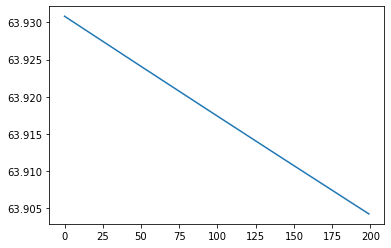

Learning Rate: 0.0001 Regularization: 1e-05
Epoch 0, loss: 63.894832
Epoch 1, loss: 63.894697
Epoch 2, loss: 63.894563
Epoch 3, loss: 63.894429
Epoch 4, loss: 63.894295
Epoch 5, loss: 63.894161
Epoch 6, loss: 63.894028
Epoch 7, loss: 63.893894
Epoch 8, loss: 63.893760
Epoch 9, loss: 63.893626
Epoch 10, loss: 63.893492
Epoch 11, loss: 63.893358
Epoch 12, loss: 63.893224
Epoch 13, loss: 63.893090
Epoch 14, loss: 63.892956
Epoch 15, loss: 63.892823
Epoch 16, loss: 63.892689
Epoch 17, loss: 63.892555
Epoch 18, loss: 63.892421
Epoch 19, loss: 63.892287
Epoch 20, loss: 63.892154
Epoch 21, loss: 63.892020
Epoch 22, loss: 63.891886
Epoch 23, loss: 63.891753
Epoch 24, loss: 63.891619
Epoch 25, loss: 63.891485
Epoch 26, loss: 63.891352
Epoch 27, loss: 63.891218
Epoch 28, loss: 63.891084
Epoch 29, loss: 63.890951
Epoch 30, loss: 63.890817
Epoch 31, loss: 63.890684
Epoch 32, loss: 63.890550
Epoch 33, loss: 63.890417
Epoch 34, loss: 63.890283
Epoch 35, loss: 63.890150
Epoch 36, loss: 63.890016
Epoc

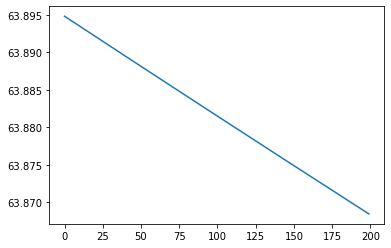

Learning Rate: 0.0001 Regularization: 1e-06
Epoch 0, loss: 63.867393
Epoch 1, loss: 63.867262
Epoch 2, loss: 63.867131
Epoch 3, loss: 63.867000
Epoch 4, loss: 63.866869
Epoch 5, loss: 63.866738
Epoch 6, loss: 63.866607
Epoch 7, loss: 63.866476
Epoch 8, loss: 63.866345
Epoch 9, loss: 63.866214
Epoch 10, loss: 63.866083
Epoch 11, loss: 63.865952
Epoch 12, loss: 63.865821
Epoch 13, loss: 63.865690
Epoch 14, loss: 63.865560
Epoch 15, loss: 63.865429
Epoch 16, loss: 63.865298
Epoch 17, loss: 63.865167
Epoch 18, loss: 63.865036
Epoch 19, loss: 63.864905
Epoch 20, loss: 63.864775
Epoch 21, loss: 63.864644
Epoch 22, loss: 63.864513
Epoch 23, loss: 63.864382
Epoch 24, loss: 63.864251
Epoch 25, loss: 63.864121
Epoch 26, loss: 63.863990
Epoch 27, loss: 63.863859
Epoch 28, loss: 63.863729
Epoch 29, loss: 63.863598
Epoch 30, loss: 63.863467
Epoch 31, loss: 63.863337
Epoch 32, loss: 63.863206
Epoch 33, loss: 63.863076
Epoch 34, loss: 63.862945
Epoch 35, loss: 63.862814
Epoch 36, loss: 63.862684
Epoc

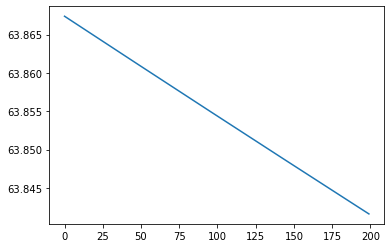

Learning Rate: 1e-05 Regularization: 0.0001
Epoch 0, loss: 63.852146
Epoch 1, loss: 63.852133
Epoch 2, loss: 63.852121
Epoch 3, loss: 63.852108
Epoch 4, loss: 63.852096
Epoch 5, loss: 63.852083
Epoch 6, loss: 63.852070
Epoch 7, loss: 63.852058
Epoch 8, loss: 63.852045
Epoch 9, loss: 63.852033
Epoch 10, loss: 63.852020
Epoch 11, loss: 63.852007
Epoch 12, loss: 63.851995
Epoch 13, loss: 63.851982
Epoch 14, loss: 63.851970
Epoch 15, loss: 63.851957
Epoch 16, loss: 63.851944
Epoch 17, loss: 63.851932
Epoch 18, loss: 63.851919
Epoch 19, loss: 63.851907
Epoch 20, loss: 63.851894
Epoch 21, loss: 63.851881
Epoch 22, loss: 63.851869
Epoch 23, loss: 63.851856
Epoch 24, loss: 63.851844
Epoch 25, loss: 63.851831
Epoch 26, loss: 63.851818
Epoch 27, loss: 63.851806
Epoch 28, loss: 63.851793
Epoch 29, loss: 63.851781
Epoch 30, loss: 63.851768
Epoch 31, loss: 63.851755
Epoch 32, loss: 63.851743
Epoch 33, loss: 63.851730
Epoch 34, loss: 63.851718
Epoch 35, loss: 63.851705
Epoch 36, loss: 63.851693
Epoc

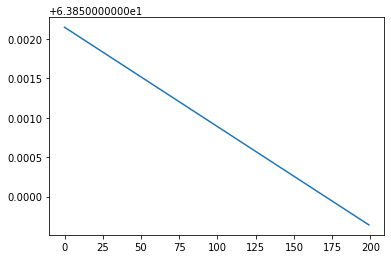

Learning Rate: 1e-05 Regularization: 1e-05
Epoch 0, loss: 63.839961
Epoch 1, loss: 63.839949
Epoch 2, loss: 63.839936
Epoch 3, loss: 63.839923
Epoch 4, loss: 63.839910
Epoch 5, loss: 63.839898
Epoch 6, loss: 63.839885
Epoch 7, loss: 63.839872
Epoch 8, loss: 63.839859
Epoch 9, loss: 63.839846
Epoch 10, loss: 63.839834
Epoch 11, loss: 63.839821
Epoch 12, loss: 63.839808
Epoch 13, loss: 63.839795
Epoch 14, loss: 63.839783
Epoch 15, loss: 63.839770
Epoch 16, loss: 63.839757
Epoch 17, loss: 63.839744
Epoch 18, loss: 63.839732
Epoch 19, loss: 63.839719
Epoch 20, loss: 63.839706
Epoch 21, loss: 63.839693
Epoch 22, loss: 63.839681
Epoch 23, loss: 63.839668
Epoch 24, loss: 63.839655
Epoch 25, loss: 63.839642
Epoch 26, loss: 63.839630
Epoch 27, loss: 63.839617
Epoch 28, loss: 63.839604
Epoch 29, loss: 63.839591
Epoch 30, loss: 63.839579
Epoch 31, loss: 63.839566
Epoch 32, loss: 63.839553
Epoch 33, loss: 63.839540
Epoch 34, loss: 63.839527
Epoch 35, loss: 63.839515
Epoch 36, loss: 63.839502
Epoch

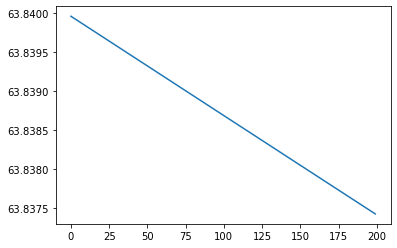

Learning Rate: 1e-05 Regularization: 1e-06
Epoch 0, loss: 63.836443
Epoch 1, loss: 63.836430
Epoch 2, loss: 63.836418
Epoch 3, loss: 63.836405
Epoch 4, loss: 63.836392
Epoch 5, loss: 63.836379
Epoch 6, loss: 63.836367
Epoch 7, loss: 63.836354
Epoch 8, loss: 63.836341
Epoch 9, loss: 63.836328
Epoch 10, loss: 63.836316
Epoch 11, loss: 63.836303
Epoch 12, loss: 63.836290
Epoch 13, loss: 63.836277
Epoch 14, loss: 63.836265
Epoch 15, loss: 63.836252
Epoch 16, loss: 63.836239
Epoch 17, loss: 63.836226
Epoch 18, loss: 63.836214
Epoch 19, loss: 63.836201
Epoch 20, loss: 63.836188
Epoch 21, loss: 63.836175
Epoch 22, loss: 63.836163
Epoch 23, loss: 63.836150
Epoch 24, loss: 63.836137
Epoch 25, loss: 63.836124
Epoch 26, loss: 63.836112
Epoch 27, loss: 63.836099
Epoch 28, loss: 63.836086
Epoch 29, loss: 63.836073
Epoch 30, loss: 63.836061
Epoch 31, loss: 63.836048
Epoch 32, loss: 63.836035
Epoch 33, loss: 63.836022
Epoch 34, loss: 63.836010
Epoch 35, loss: 63.835997
Epoch 36, loss: 63.835984
Epoch

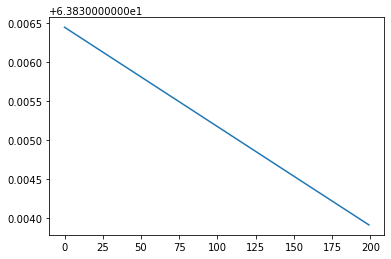

best validation accuracy achieved: 0.241000


In [73]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for lr in learning_rates:
    for rs in reg_strengths:
        print('Learning Rate:', lr, 'Regularization:', rs)
        # На каждом этапе я забыл создавать новый classifier, чтобы обнулять веса и loss
        # Поэтому каждый следующий fit происходил на старых весах, но с новыми тренировочными параматрами
        # classifier = linear_classifer.LinearSoftmaxClassifier()
        loss_history = classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=lr, batch_size=batch_size, reg=rs)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier

        print("Accuracy: ", accuracy)
        plt.plot(loss_history)
        plt.show()

print('best validation accuracy achieved: %f' % best_val_accuracy)

# Какой же точности мы добились на тестовых данных?

In [88]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

import pickle
from datetime import datetime

dt = str(datetime.now()).split('.')[0].replace(' ', '_')
with open(f'{dt}.pkl', 'wb') as fout:
    pickle.dump(best_classifier, fout)

Linear softmax classifier test set accuracy: 0.202000
